## Load modules and data

In [11]:
#Base
import sys, os
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import scipy.stats as st
from tqdm.notebook import trange, tqdm
from statsmodels.stats.multitest import fdrcorrection
import ray

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.gridspec as gridspec

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

#V1DD
from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis import StimulusAnalysis
from allen_v1dd.stimulus_analysis.correlation import calculate_correlation, ProgressBar
from allen_v1dd.stimulus_analysis.natural_scenes import NaturalScenes
from allen_v1dd.stimulus_analysis.drifting_gratings import DriftingGratings

#Network 
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import greedy_modularity_communities, naive_greedy_modularity_communities
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency

#CCM
from delay_embedding import surrogate as S
from delay_embedding import helpers as H

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/plots'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)

In [3]:
##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [5]:
## Interpolate all planes to same time
data_list_interp = sess.interpolate_all_plane_traces_to_common_time_series(trace_type='dff',valid_only=False,reload=True)

#Get number of neurons per plane
nNeurons_plane = [len(t) for t in data_list_interp]
nNeurons_plane
# nNeurons_plane = [1234, 1222, 1482, 1279, 1158, 1148]


[1234, 1222, 1482, 1279, 1158, 1148]

In [6]:
ts = data_list_interp[0]['time'].values


(21616,)

In [8]:
for ii, data_xr in enumerate(data_list_interp):
    dF_traces = data_xr.to_numpy()
    ts = data_xr['time'].values
    plane = ii + 1
    np.savez(f'/home/david.wyrick/projects/V1DD/data/dff_{mouse_id}_{col}{vol}_{plane}_all-rois.npz',dF_traces=dF_traces,ts=ts)

In [6]:
#Get stimulus table
stim_table, stim_meta = sess.get_stimulus_table("natural_images_12")
tStart = stim_table.loc[0,'start']
tEnd = stim_table.loc[479,'end']

In [7]:
plane = 3
#Select only valid cells
rois = np.array(sess.get_rois(plane))
mask = sess.is_roi_valid(plane)

In [6]:
## Create stimulus object for natural scenes analysis
ns12_events = NaturalScenes(sess, 3, ns_type="natural_images_12",trace_type="events")

#Calculate metrics 
ns12_events_metrics = ns12_events.metrics
ns12_events_metrics = ns12_events_metrics[mask]
ns12_events_metrics

NameError: name 'mask' is not defined

In [9]:
ns12_events_metrics.columns

Index(['mean_responses', 'pref_response', 'pref_img', 'pref_img_idx',
       'z_score', 'z_score_responses', 'response_p', 'frac_responsive_trials',
       'lifetime_sparseness', 'p_trial_responses', 'sig_trial_responses',
       'is_valid', 'chisq_response_p', 'null_dist_multi_mean',
       'null_dist_multi_std', 'null_dist_single_mean', 'null_dist_single_std'],
      dtype='object')

In [9]:
## Create stimulus object for natural scenes analysis
ns12_cascade = NaturalScenes(sess, 3, ns_type="natural_images_12",trace_type="cascade")

#Calculate metrics 
ns12_cascade_metrics = ns12_cascade.metrics
ns12_cascade_metrics = ns12_cascade_metrics[mask]
ns12_cascade_metrics

,mean_responses,pref_response,pref_img,pref_img_idx,z_score,z_score_responses,response_p,frac_responsive_trials,lifetime_sparseness,p_trial_responses,sig_trial_responses,is_valid,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std
0,"[0.05773347625590759, 0.06745874708056476, 0.0...",0.077737,29,7,10.280799,"[6.449933429581996, 8.312408274900912, 7.99537...",0.0,0.125,0.865056,0.979697,False,True,0.992,0.024054,0.005222,0.024353,0.032372
1,"[0.27900682717590825, 0.19723234970242629, 0.2...",0.295946,5,2,29.42233,"[27.503725743335703, 18.241654540524337, 29.42...",0.0,0.525,0.747316,0.004222,True,True,0.03,0.036177,0.008829,0.035621,0.05181
2,"[0.06934562342003119, 0.028443421423492054, 0....",0.108632,9,4,12.382839,"[6.249009877705516, -0.13702820525268578, 5.53...",0.0,0.2,0.746775,0.017173,True,True,0.018,0.029321,0.006405,0.030134,0.042341
3,"[0.04946343301503475, 0.0303667002151883, 0.04...",0.055274,47,9,-1.535138,"[-1.6474108698907868, -2.0163762330065387, -1....",0.9629,0.025,0.915738,0.992012,False,True,0.947,0.134729,0.051758,0.129191,0.316844
4,"[0.08327440431380637, 0.1958041528026797, 0.08...",0.267717,23,5,10.669781,"[1.7363256156851847, 7.186703776361524, 1.8734...",0.0,0.35,0.798134,0.015744,True,True,0.008,0.047426,0.020646,0.047383,0.129229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,"[0.0711011353922828, 0.051898392195727186, 0.0...",0.071101,2,0,4.172371,"[4.172371341154615, 1.726517359863498, 3.10685...",0.0004,0.125,0.679097,0.206594,False,True,0.229,0.038343,0.007851,0.039094,0.051134
756,"[0.03086608974393812, 0.05632116322934735, 0.0...",0.081959,23,5,6.439031,"[-0.5082145854674168, 2.9529511909334634, -0.8...",0.0,0.175,0.677184,0.0,True,True,0.0,0.034604,0.007354,0.034835,0.047865
833,"[0.04080175327489997, 0.035345070299126743, 0....",0.059519,32,8,5.25714,"[2.589663590433385, 1.812013329707051, 2.24872...",0.0013,0.175,0.75746,0.201909,False,True,0.244,0.02263,0.007017,0.022351,0.041259
848,"[0.038471728848799104, 0.03537076975135278, 0....",0.050859,5,2,1.433365,"[0.22115414552287402, -0.08229455268902763, 1....",0.0888,0.025,0.666314,0.159854,False,True,0.137,0.036212,0.010219,0.036984,0.070251


In [30]:
roi_indices = ns12_cascade_metrics.index.values
roi_indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

In [31]:
pdfdoc = PdfPages(os.path.join(PlotDir,'mean_responses_cascadevsL0.pdf'))

for iN in tqdm(roi_indices):
    fig, ax = plt.subplots(figsize=(10,6))
    plt.suptitle(f'Cascade vs L0 Deconvolution, roi {iN}')

    ax.plot(ns12_cascade_metrics.loc[iN]['mean_responses'],'-o',color=cc[1],label='Cascade')
    ax.set_ylabel('Mean spike probability',color=cc[1],fontweight='bold',fontsize=18)
    ax.set_xticks(np.arange(12),labels=np.arange(1,13))
    ax.vlines(ns12_cascade_metrics.loc[iN]['pref_img_idx'],*ax.get_ylim(),ls='--',color=cc[1])

    ax2 = ax.twinx()
    ax2.plot(ns12_events_metrics.loc[iN]['mean_responses'],'-o',color=cc[2],label='LO')
    ax2.set_ylabel('Mean event energy',color=cc[2],fontweight='bold',fontsize=18)
    ax2.vlines(ns12_events_metrics.loc[iN]['pref_img_idx'],*ax2.get_ylim(),ls='--',color=cc[2])

    pdfdoc.savefig(fig)
    plt.close(fig)
pdfdoc.close()

  0%|          | 0/483 [00:00<?, ?it/s]

In [32]:
indy = np.array(ns12_events_metrics['pref_img_idx'].values == ns12_cascade_metrics['pref_img_idx'].values,dtype=bool)
same_keys = ns12_events_metrics.index.values[indy]
same_keys = ns12_events_metrics.index.values[~indy]

In [53]:
indy.shape

(483,)

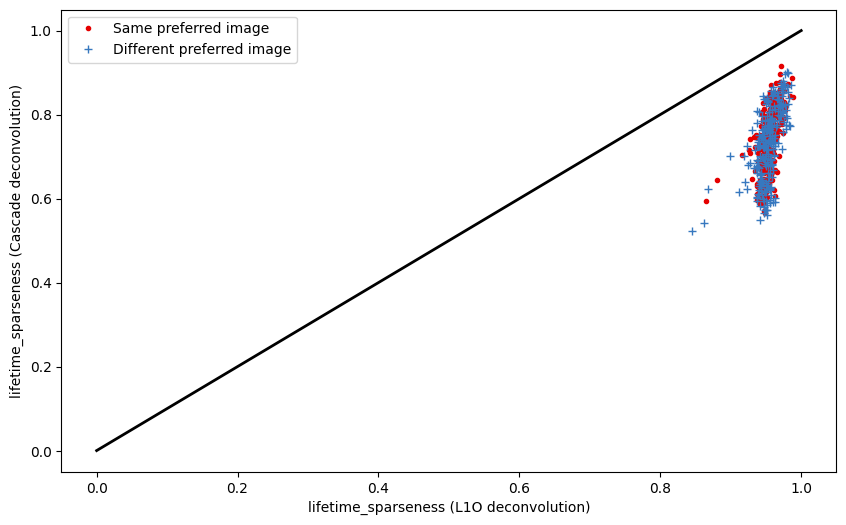

In [63]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ns12_events_metrics['lifetime_sparseness'].values[indy],ns12_cascade_metrics['lifetime_sparseness'].values[indy],'.',color=cc[1],label='Same preferred image')
ax.plot(ns12_events_metrics['lifetime_sparseness'].values[~indy],ns12_cascade_metrics['lifetime_sparseness'].values[~indy],'.',marker='+',color=cc[2],label='Different preferred image')
ax.plot([0,1],[0,1],'-k',lw=2)
ax.set_xlabel('lifetime_sparseness (L1O deconvolution)')
ax.set_ylabel('lifetime_sparseness (Cascade deconvolution)')
ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ns12_events_metrics['frac_responsive_trials'].values[indy],ns12_cascade_metrics['frac_responsive_trials'].values[indy],'.',color=cc[1],label='Same preferred image')
ax.plot(ns12_events_metrics['frac_responsive_trials'].values[~indy],ns12_cascade_metrics['frac_responsive_trials'].values[~indy],'.',marker='+',color=cc[2],label='Different preferred image')
ax.plot([0,1],[0,1],'-k',lw=2)
ax.set_xlabel('frac_responsive_trials (L1O deconvolution)')
ax.set_ylabel('frac_responsive_trials (Cascade deconvolution)')
ax.legend()

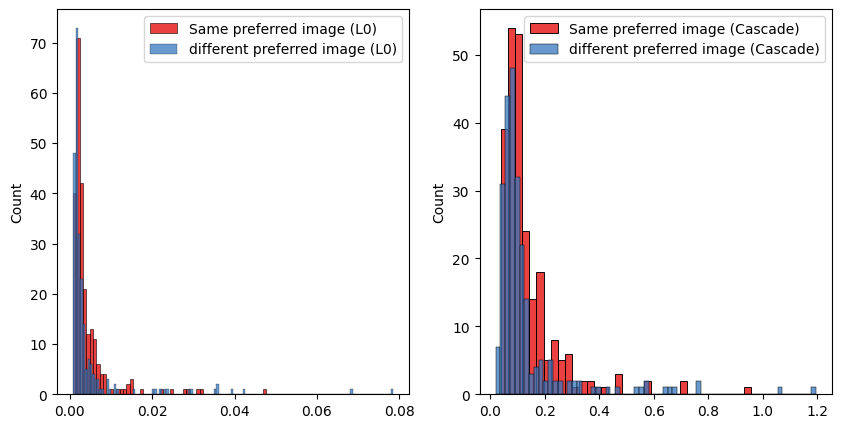

In [62]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.histplot(ns12_events_metrics['pref_response'].values[indy],ax=axes[0],color=cc[1],label='Same preferred image (L0)')
sns.histplot(ns12_events_metrics['pref_response'].values[~indy],ax=axes[0],color=cc[2],label='different preferred image (L0)')
axes[0].legend()
sns.histplot(ns12_cascade_metrics['pref_response'].values[indy],ax=axes[1],color=cc[1],label='Same preferred image (Cascade)')
sns.histplot(ns12_cascade_metrics['pref_response'].values[~indy],ax=axes[1],color=cc[2],label='different preferred image (Cascade)')
axes[1].legend()

## Cascade deconvolution

In [16]:
## Interpolate all planes to same time
data_list_interp = sess.interpolate_all_plane_traces_to_common_time_series(trace_type='dff',reload=True)

#Get number of neurons per plane
nNeurons_plane = [len(t) for t in data_list_interp]
nNeurons_plane

del data_list_interp


In [17]:
plane = 3
#Select only valid cells
rois = np.array(sess.get_rois(plane))
mask = sess.is_roi_valid(plane)


In [40]:
plane_boundaries = np.cumsum(nNeurons_plane)
spike_prob_plane3 = spike_prob[plane_boundaries[1]:plane_boundaries[2]]

In [39]:
from glob import glob
fpath = '/home/david.wyrick/projects/V1DD/data/old/predictions_dff_409828_13_natural_images_12.npz'
data = np.load(fpath)
spike_prob = data['spike_prob']
ts = data['ts']
nT = spike_prob.shape[-1]

In [50]:
from glob import glob
fpath = '/home/david.wyrick/projects/V1DD/data/predictions_dff_409828_13_3_all-rois.npz'
data = np.load(fpath)
spike_prob = data['data']
ts = data['timestamps']
nT = spike_prob.shape[-1]
indy = np.where((ts >= tStart) & (ts <= tEnd))[0]

In [52]:
spike_prob.shape

(1482, 21552)

In [41]:
tmp_array = np.zeros((len(rois),nT))
tmp_array[mask] = spike_prob_plane3

In [53]:
# spike_prob_plane3 = spike_prob[plane_boundaries[1]:plane_boundaries[2]]

traces = xr.DataArray(
    spike_prob[:,indy],
    name='events',
    dims=("roi", "time"),
    coords=dict(roi=rois, time=ts[indy])
)



In [54]:
## Create stimulus object for natural scenes analysis
ns12_cascade = NaturalScenes(sess, 3, ns_type="natural_images_12",trace_type="cascade")
response_time_window = ns12_cascade.response_time_window
response_time_window

(0, 0.33)

In [55]:
bins = []
ns12_cascade._sweep_responses = np.zeros((len(stim_table),len(rois)), dtype=float)

for i in stim_table.index:
    start = stim_table.at[i, "start"]
    tmp_x = traces.sel(time=slice(start+response_time_window[0], start+response_time_window[1]))
    bins.append(tmp_x.shape[-1])
    response = tmp_x.mean("time")
    ns12_cascade._sweep_responses[i] = response

In [56]:
ns12_cascade._trial_responses = xr.DataArray(
    data=np.nan,
    name="trial_responses",
    dims=("roi", "image", "trial"),
    coords=dict(
        roi=rois,
        image=ns12_cascade.image_indices,
        trial=range(ns12_cascade.n_trials)
    )
)

for imgID in ns12_cascade.image_indices:
    stim_idx = ns12_cascade.get_stim_idx(imgID)
    ns12_cascade._trial_responses.loc[
        dict(image=imgID, trial=range(len(stim_idx)))
    ] = ns12_cascade.sweep_responses[stim_idx, :].T # shape (n_rois, len(stim_idx))

In [57]:
#Calculate metrics 
ns12_cascade_metrics = ns12_cascade.metrics
ns12_cascade_metrics

,mean_responses,pref_response,pref_img,pref_img_idx,z_score,z_score_responses,response_p,frac_responsive_trials,lifetime_sparseness,p_trial_responses,sig_trial_responses,is_valid,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std
0,"[0.05773347625590759, 0.06745874708056476, 0.0...",0.077737,29,7,10.379644,"[6.508593199185604, 8.390605328716632, 8.07111...",0.0,0.125,0.865054,0.979693,False,True,0.994,0.0241,0.005167,0.02412,0.031569
1,"[0.27900682717590825, 0.19723234970242629, 0.2...",0.299634,5,2,29.166024,"[26.88147908301157, 17.82450497113414, 29.1660...",0.0,0.525,0.747115,0.003821,True,True,0.024,0.036297,0.009029,0.035464,0.052187
2,"[0.06934562342003119, 0.028443421423492054, 0....",0.108632,9,4,12.260555,"[6.1770271455753125, -0.156641439131128, 5.605...",0.0,0.2,0.746714,0.017425,True,True,0.022,0.029455,0.006458,0.030363,0.0426
3,"[0.04946343301503475, 0.0303667002151883, 0.04...",0.055274,47,9,-1.535753,"[-1.6484422171394126, -2.018777003908038, -1.6...",0.9622,0.025,0.915675,0.991904,False,True,0.945,0.134467,0.051566,0.136073,0.326151
4,"[0.08327440431380637, 0.1958041528026797, 0.08...",0.267717,23,5,10.769049,"[1.7468374774146889, 7.251366696133568, 1.9123...",0.0,0.35,0.798009,0.01589,True,True,0.011,0.047564,0.020443,0.046334,0.122585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,NaN,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.433,0.035955,0.006366,0.035685,0.03985
1478,NaN,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.113,0.01081,0.002986,0.011092,0.019563
1479,NaN,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.581,0.025421,0.005366,0.025462,0.033963
1480,NaN,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.003,0.044334,0.007908,0.044236,0.049368


In [58]:
np.sum(ns12_metrics['pref_img_idx'].values[mask] == ns12_cascade_metrics['pref_img_idx'].values[mask])/np.sum(mask)

0.9958592132505176

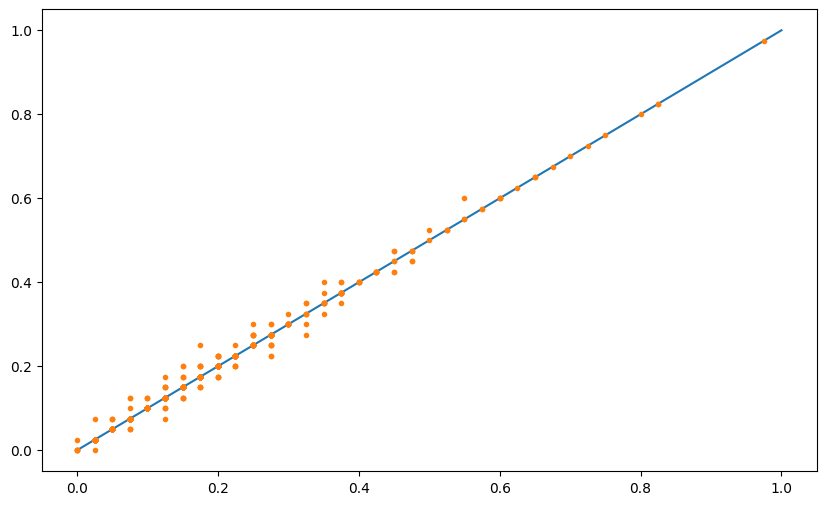

In [60]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot([0,1],[0,1])
ax.plot(ns12_cascade_metrics['frac_responsive_trials'].values[mask],ns12_metrics['frac_responsive_trials'].values[mask],'.')

## Run on all sessions

In [4]:
mouse = 409828 # selected for EM
column = 1

session_ids = client.get_all_session_ids()
# session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column) and s[9] == "3"]
session_ids = [s for s in session_ids if s.startswith(f"M{mouse}") and s[8] == str(column)]

print("Sessions to load:")
print(session_ids)

Sessions to load:
['M409828_11', 'M409828_12', 'M409828_13', 'M409828_14', 'M409828_15', 'M409828_16', 'M409828_17', 'M409828_18', 'M409828_19', 'M409828_1a', 'M409828_1b', 'M409828_1c', 'M409828_1d', 'M409828_1e', 'M409828_1f']


In [5]:
sessions = []

for session_id in tqdm(session_ids):
    session = client.load_ophys_session(session_id=session_id)
    sessions.append(session)

print(f"Loaded {len(sessions)} ophys sessions")

  0%|          | 0/15 [00:00<?, ?it/s]

Loaded 15 ophys sessions


In [ ]:
ns12_cascade = NaturalScenes(sess, 3, ns_type="natural_images_12",trace_type="cascade")

#Calculate metrics 
ns12_cascade_metrics = ns12_cascade.metrics
ns12_cascade_metrics = ns12_cascade_metrics[mask]
ns12_cascade_metrics

In [10]:
plane_info = [] # holds (mouse, column, volume, plane)
ns12 = []
ns118 = []

with tqdm(desc="Loading natural scene analyses", total=sum(len(s.get_planes()) for s in sessions)) as pbar:
    for session in sessions:
        for plane in session.get_planes():
            plane_info.append((session.get_mouse_id(), session.get_column_id(), session.get_volume_id(), plane))


            ns12.append(NaturalScenes(session, plane, ns_type="natural_images_12"))
            ns118.append(NaturalScenes(session, plane, ns_type="natural_images"))
            pbar.update()

Loading natural scene analyses:   0%|          | 0/40 [00:00<?, ?it/s]

In [12]:
RECOMPUTE_METRICS = True
DF_SAVE_DIR = r"/home/david.wyrick/Git/allen_v1dd/dataframes"

if RECOMPUTE_METRICS:

    # Concatenate across the different planes
    print("Concatenating ns12 metrics...")
    ns12_metrics = StimulusAnalysis.concat_metrics(ns12)
 
    print("Merging ns118 metrics...")
    ns118_metrics = StimulusAnalysis.concat_metrics(ns118)
 
    print("Done.", len(ns118_metrics), "total ROIs.")
    ns12_metrics.to_csv(os.path.join(DF_SAVE_DIR, "ns12_metrics_col1.csv"))
    ns118_metrics.to_csv(os.path.join(DF_SAVE_DIR, "ns118_metrics_col1.csv"))

ns12_metrics

Concatenating ns12 metrics...
